# Time Series Forecasting

### Name: Deepan Sanghavi

In [1]:
import pandas as pd
import numpy as np
from numpy import inf
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import seaborn as sns
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
import warnings
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

##### Reading Data From CSV and putting in dictionary

In [2]:
data = pd.read_csv("./Forecasting_Exercise.csv")
data.columns = [c.replace(' ', '_') for c in data.columns]
data.head()


,Item_Number,Historical_Period_1,Historical_Period_2,Historical_Period_3,Historical_Period_4,Historical_Period_5,Historical_Period_6,Historical_Period_7,Historical_Period_8,Historical_Period_9,...,Historical_Period_147,Historical_Period_148,Historical_Period_149,Historical_Period_150,Historical_Period_151,Historical_Period_152,Historical_Period_153,Historical_Period_154,Historical_Period_155,Historical_Period_156
0,204000,0,2,4,3,0,0,0,0,1,...,7,19,10,13,9,17,12,32,19,24
1,799620,0,0,0,0,0,0,0,0,0,...,13,19,2,10,5,6,30,14,16,12
2,13820000,0,0,0,4,25,16,22,14,30,...,40,0,25,26,29,23,19,15,66,24
3,9.92E+15,0,6,9,1,3,34,8,0,6,...,0,0,0,0,1,10,11,2,12,25
4,007f74,226,181,371,246,225,199,236,101,556,...,27,45,59,29,114,108,31,48,60,37


##### Data Exploration

- I started with visualizing each product wise and tried to understand at randome plots of few products. Information that I got initially is there are products whose plots did not look stationary and there were few additive and more than few multiplicative trends. Further, there are few plots which have lot of zeroes initially and suddenly spikes up.
- Such trends can be managed if we can remove the multiplicative factor from it. Moreover, there were seasonal component as well which needs to be removed for stationary assumption. As there are 100 products, it is difficult to visualize each plots.
- So, I decided to **Cluster** all the products and analyze products based on which category of cluster they fall into. Over here, I am trying to find similar combination so that I can perform similar operations on similar series

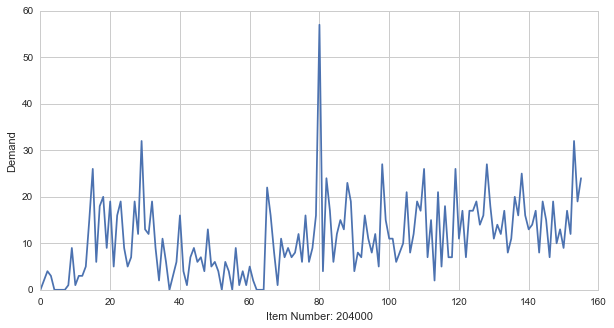

<function __main__.filter_based_on_product>

In [3]:
def filter_based_on_product(Products):
    sns.set(style="whitegrid", color_codes=True)
    temp = data.loc[data["Item_Number"] == Products]
    x = temp.iloc[0,1:].tolist()
    fig=plt.figure(figsize=(10, 5))
    plt.plot(x)
    plt.ylabel('Demand')
    plt.xlabel("Item Number: "+ Products)
    plt.show()
interact(filter_based_on_product, Products=data.Item_Number.unique().tolist())

##### Clustering

- Before Applying Clustering, first I need to find out number of cluster which can be done using elbow method.
- Using euclidean distance, I are measuring distance between clusters and data point

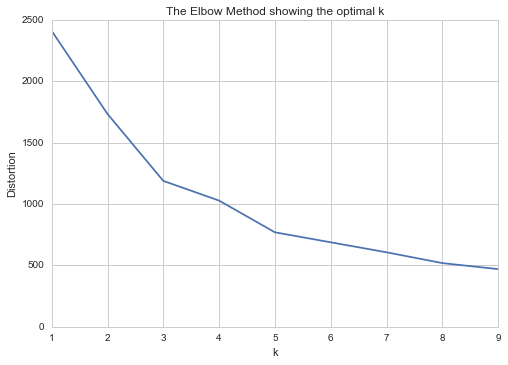

In [5]:
#Calculating euclidean distance from each cluster and plotting for elbow curve (Decide number of clusters)
new_DF = data
distortions = []
K = range(1,10)
X = new_DF.iloc[:,1:]
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

- Once Clustering is done, I are applying K-means which uses euclidean distance between centroids of clusters as measure to distinguish data points. From, Elbow method, we got the number of clusters=5 which is given as an input to k-means.

- Once, clusters are found, I am keeping a track of Product - Cluster which it belongs to relationship. Also, just for knowledge, I am checking number of products given to each cluster. We can see that, there are large number of products to cluster 0 and hence there are large number of similar products.

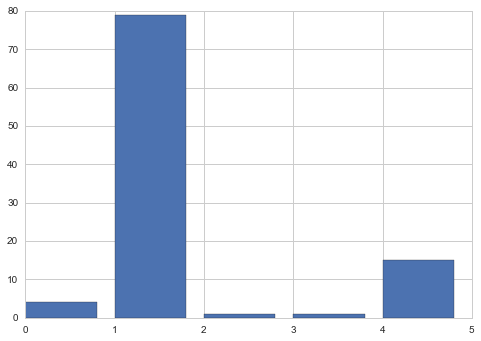

,Cluster,Product_ID
0,0,5f3dc6
1,1,204000
2,2,68c583
3,3,679a21
4,4,007f74


In [6]:
#Number of clusters are 4

#Applying K means

kmeans = KMeans(n_clusters = 5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

#Cluster Distribution
kmeans_labels = pd.DataFrame(kmeans.labels_, columns = ["Cluster"])
kmeans_labels["Product_ID"] = pd.DataFrame(new_DF['Item_Number'])
plt.bar(kmeans_labels.Cluster.value_counts().index,kmeans_labels.Cluster.value_counts().values)
plt.show()

#Cluster Product Combination
clusterDF = kmeans_labels.groupby('Cluster').first().reset_index()
clusterDF.head()

##### Identify P (AR component),Q (MA component) values for ARIMA

- Once clusters are identified which is 5 in our case, next step is to find out p and q values by looking at the autocorrelation and partial autocorrelation plots. Below I have shown interactive way to see the plot based on clusters.

0


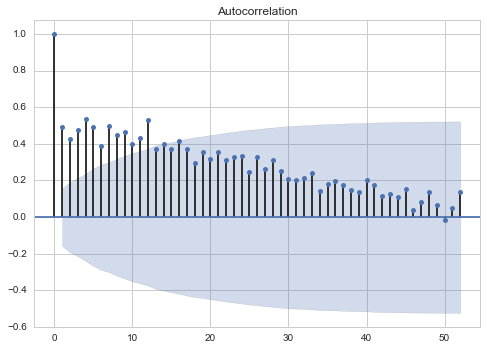

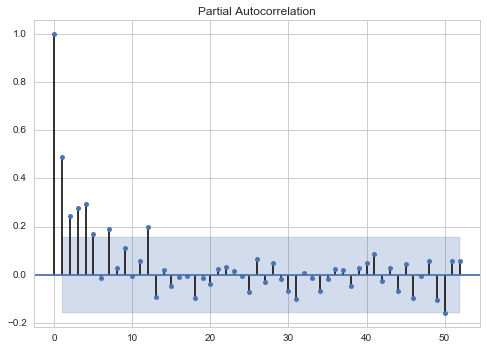

<function __main__.autocorrelation_based_on_cluster>

In [16]:
#Check autocorrelation and partial correlation plots for ARIMA

def autocorrelation_based_on_cluster(Clusters):
    sns.set(style="whitegrid", color_codes=True)
    yy = str(clusterDF.loc[clusterDF["Cluster"] == int(Clusters),"Product_ID"].values[0])
    #print(yy)
    temp = new_DF.loc[new_DF["Item_Number"] == yy]
    temp
    x = temp.iloc[0,1:].tolist()
    fig=plt.figure(figsize = (20, 10))
    plot_acf(x, lags = 52)
    plot_pacf(x, lags = 52)
    plt.show()
interact(autocorrelation_based_on_cluster, Clusters = clusterDF.Cluster.unique().tolist())

Based on above graphs, I have hardcoded the p and q values for ARIMA

In [ ]:
#Define p,d,q value for each cluster

pq_dict = {0: (4, 0, 1), 1: (5, 0, 1), 2: (3, 0, 1), 3: (3, 0, 2), 4: (4, 0, 1)}
# pq_dict

In [644]:
#transposing data for ease
data_transpose = data.transpose()
data_transpose.columns = data_transpose.iloc[0]
data_transpose = data_transpose.drop(["Item_Number"])
#data_transpose.head()

##### Making the data stationary

- A series is stationary means its means and variance are constant over time.

- Basic requirement for ARIMA is that the input series should be stationary. Firstly, using Dickey-Fuller test (ADF), we are finding whether the series is stationary or not. According to ADF test, null hypothesis is the series is non stationary and hence, if p value is less than 0.05, that means series is stationary.

- If series is not stationary, we have to make it stationary by removing trend and seasonality from the series. This can be done by using Seasonal Trend decomposition using Loess method or by differencing the series. My method is to apply log tranform first so that it is robust against outliers, than apply decomposition and identify all components. After that, remove trend and seasonality and bring the data back to original scale by taking exponential of data. **Beware of infinty values**

- Hence, I am creating stationary series and storing it in dictionary with key as a product and value as the series.

- Below graph has 4 components: Actual, Trend, Seasonality, Noise

- Important aspect of this logic is finding out whether series is multiplicative or additive. As we have 100 combinations, it is difficult to find out. But, technique that I am using is I am comparing mean of two halves and if there is large difference than it is multiplicative or else assitive. I did this because there are large number of records where initially there are small values and then it increases in multilicative way.

- Additive series = Trend + Seasonality + noise

- Multiplicative = Trend * Seasonality * Noise

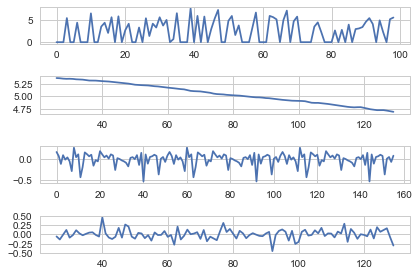

In [708]:
#Output of this block is stationary series

trend = seasonal = observed = no_trend_seasonal = 0
def decomposition(data,x):
    global trend, seasonal, residual, observed, no_trend_seasonal
    data=data.apply(pd.to_numeric,axis=0)
    data=data.apply(np.log,axis=0)
    data=data.replace(-np.inf,0)
    decomposition = seasonal_decompose(data.iloc[:,x].tolist(),freq=52)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    observed=decomposition.observed
    first_half_mean=np.mean(observed[:78])
    second_half_mean=np.mean(observed[78:])
    
    #multiplicative or addtiive
    if(second_half_mean/(first_half_mean+0.1)>5):
        no_trend_seasonal=(observed/trend)/seasonal
    else:
        no_trend_seasonal=observed-trend-seasonal
    
    no_trend_seasonal=np.exp(no_trend_seasonal)
    no_trend_seasonal[no_trend_seasonal== inf]=0
    no_trend_seasonal[no_trend_seasonal== -inf]=0
    if(x==(len(data_transpose.columns)-1)):
        plt.subplot(411)
        plt.plot(data.iloc[0,1:].tolist(), label='_nolegend_')
        plt.subplot(412)
        plt.plot(trend, label='_nolegend_')
        plt.subplot(413)
        plt.plot(seasonal,label='_nolegend_')
        plt.subplot(414)
        plt.plot(residual, label='_nolegend_')
        plt.tight_layout()
        plt.show()
    return (no_trend_seasonal)


def adf_test(data,x):
    data=data.iloc[:,x].tolist()
    #print(type(data))
    #data=data[np.logical_not(np.isnan(data))]
    dftest = adfuller((data), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print dfoutput
    return dfoutput[1]<0.05


#If not stationary then decompose and make it stationary

dict_series={}
for x in range(0,len(data_transpose.columns)):
    product_id = data_transpose.columns[x]
    stationary = adf_test(data_transpose,x)
    #print(stationary)
    if(not stationary):
        dict_series[product_id] = np.asarray(decomposition(data_transpose,x))
    else:
        dict_series[product_id] = np.asarray(data_transpose.iloc[:,x].tolist())

- I handled NaN values over here because while decomposition, it performs Moving average with window size 52 and because of that, initial 26 values and last 26 values become NaN.
- These values are being replaced by mean of the series because that is the most basic approach that is being followed while dealing with time series.

- Also, I am saving all the stationary series in new_DF which will be used further in ARIMA

In [709]:
#Remove NA values which is cause due to moving average
for key, value in dict_series.iteritems():
    dict_series[key] = np.where(np.isnan(value), np.ma.array(value, mask=np.isnan(value)).mean(axis=0), value)
#dict_series

#Transposing back to normal

new_DF = pd.DataFrame.from_dict(dict_series)
new_DF = new_DF.transpose()
new_DF.index.names = ['Item_Number']
new_DF = new_DF.reset_index()
new_DF.head()

,Item_Number,0,1,2,3,4,5,6,7,8,...,146,147,148,149,150,151,152,153,154,155
0,007f74,226.000000,181.000000,371.000000,246.000000,225.000000,199.000000,236.000000,101.000000,556.000000,...,27.000000,45.000000,59.000000,29.000000,114.000000,108.000000,31.000000,48.000000,60.000000,37.000000
1,022fa2,0.974722,0.974722,0.974722,0.974722,0.974722,0.974722,0.974722,0.974722,0.974722,...,0.974722,0.974722,0.974722,0.974722,0.974722,0.974722,0.974722,0.974722,0.974722,0.974722
2,0c73cc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,26.000000,0.000000,30.000000,109.000000,22.000000,13.000000,44.000000,32.000000,6.000000,8.000000
3,0eefff,80.000000,67.000000,44.000000,33.000000,33.000000,63.000000,76.000000,3.000000,73.000000,...,19.000000,15.000000,33.000000,11.000000,10.000000,98.000000,35.000000,1.000000,18.000000,0.000000
4,0f2748,0.983039,0.983039,0.983039,0.983039,0.983039,0.983039,0.983039,0.983039,0.983039,...,0.983039,0.983039,0.983039,0.983039,0.983039,0.983039,0.983039,0.983039,0.983039,0.983039


##### ARIMA

- Reason for using arima is that for univariate data, as in our case, ARIMA is the most famous time series algorthms which uses the assumption of stationarity. I have used this earlier and hence, I am using it as my first algorithm.

- I am using RMSE value as a metric because other metric like MAPE gives biased results by puting heavy penalty on small values compared to large values. We have some product with reall small values and some with large. Hence, I used RMSE as squaring reduces the effect of difference between small and large values.

- As asked for, I am doing 52 step forecast

In [720]:
#Applying ARIMA as we have p, d ,q values

def apply_ARIMA_train_test(train_data, test_data, order, prod_ID):
    model = ARIMA(train_data, order = order)
    model_fit = model.fit(disp = 0)
    prediction = model_fit.forecast(steps = 52)[0]
    return sqrt(mean_squared_error(test_data, prediction)),prediction


##### Initial approach

- Initially, I was thinking of creating Training set (first 2 years) and Testing set (one or latest year). Train different models like ARIMA and other models that will come ahead. Test their accuracy on test set and which ever is perfoming best, go ahead with that model. I was planning to use RMSE.

- But, Later I changed my approach because I found out that for large number of products, initial 2 years had no demand and there was a sudden increase in demand. Hence, in such as case, this method won't work.

- Example of such a data is shown below:

- There are many such examples.

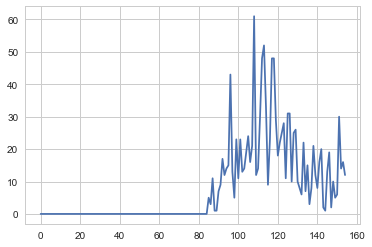

In [727]:
plt.plot(data_transpose["799620"].values[1:])
plt.show()

##### Test and Train set

I figured later that this methods is not that useful

In [ ]:
# Creating Traing and Test set 

cols = ['Item_Number'] + list(new_DF.iloc[:, 1:105])
training_set = new_DF[cols]
cols = ['Item_Number'] + list(new_DF.iloc[:, 105:])
test_set = new_DF[cols]

- Below we are calling ARIMA function bby passing correct p and q values based on clustering. But, I faced an issue where there were 7 products of which p and q values are inappropriate according to ARIMA.
- This can happen because clusters are not 100% correct. Hence, either one can manually decide p and q values using below interactive visualization or jsut give them 0. I chose the second option.
- According to me it won't harm the prediction as it is only 7 products and there are other methods which can take care of these products

In [ ]:
# give order (0,0,0) if there is an issue in p,q values of product. This happens when you impute incorrect p and q values
order_dict = {}
rmse_dict = {}
prediction_test={}
temp1 = []
temp2 =[]
lingerror_products = []
valerror_products = []
for index, row in training_set.iterrows():
    try:
        prod_ID = row['Item_Number']
        clusternumber=kmeans_labels.loc[kmeans_labels["Product_ID"]==prod_ID].values[0][0]
        order=pq_dict[clusternumber]
        train_data = np.asarray(row)[1:]
        test_data = np.asarray(test_set.loc[test_set['Item_Number'] == prod_ID])[0][1:]
        order_dict[prod_ID]=order
        rmse_dict[prod_ID],prediction_test[prod_ID] = apply_ARIMA_train_test(train_data, test_data, order, prod_ID)
    except ValueError:
        valerror_products.append((prod_ID, order))
        rmse_dict[prod_ID],prediction_test[prod_ID] = apply_ARIMA_train_test(train_data, test_data, (0,0,0), prod_ID)
        order_dict[prod_ID]=(0,0,0)
    except LinAlgError:
        lingerror_products.append((prod_ID, order))
        rmse_dict[prod_ID],prediction_test[prod_ID] = apply_ARIMA_train_test(train_data, test_data, (0,0,0), prod_ID)
        order_dict[prod_ID]=(0,0,0)

In [729]:
# These are the products with issues

print(lingerror_products)
print("=====================================================================================================================")
print(valerror_products)

[('1c69c7', (4, 0, 1)), ('1da685', (4, 0, 1)), ('21b10f', (4, 0, 1)), ('7d8d39', (4, 0, 1)), ('832cce', (4, 0, 1)), ('c2e5bb', (4, 0, 1)), ('c5f6ee', (4, 0, 1)), ('c66125', (4, 0, 1)), ('c94dca', (4, 0, 1))]
[('9d68a0', (3, 0, 2))]


In [ ]:
#One way is to manually impose new values of product by looking at their plots by product. I tried this as well.

# apply_ARIMA(dict_series['21b10f'].astype(float),(0,0,1),'21b10f')
# apply_ARIMA(dict_series['7d8d39'].astype(float),(0,0,1),'7d8d39')
# apply_ARIMA(dict_series['832cce'].astype(float),(3,0,0),'832cce')
# apply_ARIMA(dict_series['1da685'].astype(float),(7,0,2),'1da685')
# apply_ARIMA(dict_series['0c73cc'].astype(float),(1,0,0),'0c73cc')
# apply_ARIMA(dict_series['63fc05'].astype(float),(2,0,2),'63fc05')
# apply_ARIMA(dict_series['7200c2'].astype(float),(4,0,3),'7200c2')

##### Autocorrelation plots based on product

In [712]:
def autocorrelation_based_on_product(Products):
    sns.set(style="whitegrid", color_codes=True)
    temp = new_DF.loc[new_DF["Item_Number"] == Products]
    x = temp.iloc[0,1:].tolist()
    fig=plt.figure(figsize=(20, 10))
    plot_acf(x,lags=52)
    plot_pacf(x,lags=52)
    plt.show()
interact(autocorrelation_based_on_product, Products=new_DF.Item_Number.unique().tolist())

<function __main__.autocorrelation_based_on_product>

- This ARIMA is function is to predict 52 points when entire data set is given as input

In [507]:
def apply_ARIMA(data, order, prod_ID):
    #order_dict[prod_ID] = order
    #print(data)
    model = ARIMA(data, order = order)
    model_fit = model.fit(disp = 0)
    yhat = model_fit.forecast(steps = 52)[0]
    return yhat

##### Supervised Learning using Feature Engineering

- Feature engineering is done to perform a supervised learning approach and apply alogrithms like linear regression and random forest
- This is done to cover inherent relationship between input that is lags of the series in this case and ouput that is single target demand
- univariate series such as time series only comprises of sequences. Hence, to cover complex behavior of input and output features, feature engineering is one of the best approach
- Apart from lags as features there are other information like month, day, holiday, season which can be combined. But, In our case it is not given that it is which year or which week or whether it is start of the year of weeks are given from between. Hence we are using only lags.
- In this case, I used 16 lags as 16 Features. reason of using 16 is I haven't seen any autocrrelation plot where there is correlation between lags with value greater than 16 (4 Weeks)
- Data is shown Below for one product

##### We applied following Algorithms

- Linear regression
- Linear regression with feature selection
- Random Forest
- Weighted Ensemble Model based on RMSE (Above Models + Arima)

##### Final Approach

- Initially, I planned to use that algorithm which gives lowest RMSE value but later, I decided to use weighted Ensemble approach
- I give weights to each model on the basis of RMSE i.e. Algorithm with lowest RMSE gets the highest weight
- Than this weights are used to calculate the predictions

Example:

Predicitons of RF=100, LinearR=120

Weight to RF=0.7, LinearR=0.3

Ensemble prediction = 100 * 0.7 + 120 * 0.3

- All Rmse are stored in model_results dictionary and prediction in prediction dictionary

In [731]:
#automate feature engineering

from math import sqrt
model_results={}
prediction={}
best_model=''
for x in range(0,len(data_transpose.columns)):
    product=data_transpose.columns[x]

#Feature Engineering using Lagged Values

    temp=pd.DataFrame(data_transpose[product])
    temp.columns=['t']
    temp_x=temp
    value=16
    for x in range(1,value+1):

        temp_x=pd.concat([temp.shift(x),temp_x],axis=1)
        cols=(temp_x.columns.values.tolist())
        del cols[0]
        cols.insert(0,"t-" + str(x))
        temp_x.columns=cols

    linear_data=temp_x.iloc[value:,]
    
#Called algorthm functions and retrieved RMSE

    regression_RMSE,FE_Regression_RMSE,RF_RMSE,Ensemble_RMSE=Ensemble(linear_data,product)
    ARIMA_RMSE = rmse_dict[product]
    model_results[product]=[regression_RMSE,FE_Regression_RMSE,RF_RMSE,Ensemble_RMSE, ARIMA_RMSE] #All RMSE values

#Find Best RMSE
#     index = model_results[product].index(min(model_results[product]))
#     if(index == 0):
#         best_model = 'Reg'
#     if(index == 1):
#         best_model = 'FE_Reg'
#     if(index == 2):
#         best_model='RF'
#     if(index == 3):
#         best_model='Ensemble'
#     if(index == 4):
#         best_model='ARIMA'

    best_model='Ensemble'
    prediction[product]=Final(linear_data,best_model,product) # All Predcition
    
linear_data.head()

,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
Historical_Period_17,255,237,273,153,184,262,267,141,289,317,229,101,180,253,267,222,220
Historical_Period_18,237,273,153,184,262,267,141,289,317,229,101,180,253,267,222,220,262
Historical_Period_19,273,153,184,262,267,141,289,317,229,101,180,253,267,222,220,262,189
Historical_Period_20,153,184,262,267,141,289,317,229,101,180,253,267,222,220,262,189,212
Historical_Period_21,184,262,267,141,289,317,229,101,180,253,267,222,220,262,189,212,257


##### Linear Regression

- Applied Log tranform to normalize the scale and make robust against outliers
- Handled Infinity values
- Brough back to same scale using exponential function
- **Predictions which are negative are made 0** as negative demand doesn't make sense

In [714]:
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error
X_train=0
def regression(linear_data):
    global X_train
    Y=(linear_data[linear_data.columns[-1]])
    X=linear_data[linear_data.columns[:-1]]
    X_train=X.iloc[:88,]
    X_test=X.iloc[88:,]
    Y_train=pd.DataFrame(Y.iloc[:88])
    Y_test=Y.iloc[88:]

    X_train=X_train.apply(pd.to_numeric,axis=0)
    X_train=X_train.apply(np.log,axis=0)
    #print(X_train)
    X_train=X_train.replace(-np.inf,0)

    Y_train=Y_train.apply(pd.to_numeric,axis=0)
    Y_train=Y_train.apply(np.log,axis=0)
    Y_train=Y_train.replace(-np.inf,0)

    X_test=X_test.apply(pd.to_numeric,axis=0)
    X_test=X_test.apply(np.log,axis=0)
    X_test=X_test.replace(-np.inf,0)

    lm = linear_model.LinearRegression()

    model = lm.fit(X_train, Y_train)

    Prediction=pd.DataFrame(model.predict(X_test))

    Prediction=Prediction.apply(np.exp,axis=0)

    Prediction[Prediction<0]=0
    
    return (Prediction,sqrt(mean_squared_error(Y_test.values,Prediction)))

##### Feature select + Linear Regression

- Penalized Linear regression by considering only important features that are influential
- Features are selected using Recursive Feature Elimination
- This was used becuase all lags are not important to predict target
- It selects the features based on importance and its regression coefficients
- Similar log transofrmation is applied

In [658]:
#Linear Regression
from sklearn.feature_selection import RFE
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error

def fe_regression(linear_data):
    Y=(linear_data[linear_data.columns[-1]])
    X=linear_data[linear_data.columns[:-1]]
    X_train=X.iloc[:88,]
    X_test=X.iloc[88:,]
    Y_train=pd.DataFrame(Y.iloc[:88])
    Y_test=Y.iloc[88:]

    X_train=X_train.apply(pd.to_numeric,axis=0)
    X_train=X_train.apply(np.log,axis=0)
    #print(X_train)
    X_train=X_train.replace(-np.inf,0)

    Y_train=Y_train.apply(pd.to_numeric,axis=0)
    Y_train=Y_train.apply(np.log,axis=0)
    Y_train=Y_train.replace(-np.inf,0)

    X_test=X_test.apply(pd.to_numeric,axis=0)
    X_test=X_test.apply(np.log,axis=0)
    X_test=X_test.replace(-np.inf,0)

    lm = RFE(linear_model.LinearRegression())
    model = lm.fit(X_train, Y_train)

    Prediction=pd.DataFrame(model.predict(X_test))
    Prediction=Prediction.apply(np.exp,axis=0)
    Prediction[Prediction<0]=0
    return (Prediction,sqrt(mean_squared_error(Y_test.values,Prediction)))

###### Random Forest

- It is used to detect non-linear or region wise pattern
- I used this because usually, it gives good results due to the concept of bagging which reduces the Variance and with considerable depth of tree, it reduces bias as well
- To tune, I tried to use grid search but for all the products, it is not posible. So, I used the generic one

In [659]:
from sklearn.ensemble import RandomForestRegressor

def RF(linear_data):

    model = RandomForestRegressor(n_estimators=500, max_depth=35, max_features="log2",min_samples_split=15)
    Y=(linear_data[linear_data.columns[-1]])
    X=linear_data[linear_data.columns[:-1]]

    X_train=X.iloc[:88,]
    X_test=X.iloc[88:,]
    Y_train=pd.DataFrame(Y.iloc[:88])
    Y_test=Y.iloc[88:]

    X_train=X_train.apply(pd.to_numeric,axis=0)
    X_train=X_train.apply(np.log,axis=0)
    #print(X_train)
    X_train=X_train.replace(-np.inf,0)

    Y_train=Y_train.apply(pd.to_numeric,axis=0)
    Y_train=Y_train.apply(np.log,axis=0)
    Y_train=Y_train.replace(-np.inf,0)

    X_test=X_test.apply(pd.to_numeric,axis=0)
    X_test=X_test.apply(np.log,axis=0)
    X_test=X_test.replace(-np.inf,0)

    model=model.fit(X_train, Y_train)

    Y_test[Y_test==0]=0.1

    Prediction=pd.DataFrame(model.predict(X_test))

    Prediction=Prediction.apply(np.exp,axis=0)


    Prediction[Prediction<0]=0

    return (Prediction,sqrt(mean_squared_error(Y_test.values,Prediction)))

##### As Explained earlier

In [660]:
def Ensemble(linear_data,product):
    Y=(linear_data[linear_data.columns[-1]])
    Y_test=Y.iloc[88:]
    
    reg_prediction, reg_RMSE = regression(linear_data)
    fe_reg_prediction, fe_reg_RMSE = fe_regression(linear_data)
    rf_prediction, rf_RMSE = RF(linear_data)
    arima_prediction = pd.DataFrame(prediction_test[product]) 
    arima_RMSE = rmse_dict[product]
    
    #Calculation to get weights for each model
    total_RMSE = reg_RMSE + fe_reg_RMSE + rf_RMSE + arima_RMSE
    A = total_RMSE - reg_RMSE
    B = total_RMSE - fe_reg_RMSE
    C = total_RMSE - rf_RMSE
    D = total_RMSE - arima_RMSE
    reg_weight = A/(A+B+C+D)
    fe_reg_weight = B/(A+B+C+D)
    rf_weight = C/(A+B+C+D)
    arima_weight = D/(A+B+C+D)
    
    #Add Ensemble Prediction in a data frame
    Ensemble_Prediction = pd.DataFrame(columns=["Prediction"])
    for x in range(0,52):
        Ensemble_Prediction.loc[x] = pd.DataFrame(reg_prediction.iloc[x]*reg_weight + fe_reg_prediction.iloc[x]*fe_reg_weight + rf_weight*rf_prediction.iloc[x] + arima_weight*arima_prediction.iloc[x])
    
    return reg_RMSE,fe_reg_RMSE,rf_RMSE,sqrt(mean_squared_error(Y_test.values,Ensemble_Prediction))
    

In [733]:
# from sklearn.model_selection import GridSearchCV

# Y=(linear_data[linear_data.columns[-1]])
# X=linear_data[linear_data.columns[:-1]]

# X_train=X.iloc[:88,]
# X_test=X.iloc[88:,]
# Y_train=pd.DataFrame(Y.iloc[:88])
# Y_test=Y.iloc[88:]

# model = RandomForestRegressor(oob_score=True)


# param_grid = { "n_estimators"      : [250,500,750],
#            "max_features"      : ["sqrt","log2"],
#            "max_depth"         : [25, 35, 40],
#            "min_samples_split" : [10, 15]}
# grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=10)
# grid_search.fit(X_train, Y_train)
# print(grid_search.best_params_)

- Below are the same functions but they are forecasting the future 52 points based on input data
- In supervised learning, forecasting is tricky
- I forecast one point, use that point as input for next cycle and forecast second. this goes on till I get 52 points.

##### reason to chose Ensemble

- It averages the results hence reducing variance
- Usually, ensemble is considered the best approach and adding weighted touch to it was compelling
- I saw the results for few combination and ensemble seemed to be perfect

In [675]:
#If Linear Regression or Random Forest or Ensemble
def Final(linear_data,best_rmse,product):
    test_temp=pd.DataFrame(linear_data.iloc[-1:,1:])
    #print(test_temp)
    test_temp.columns=np.insert(test_temp.columns[:-1].values,0,"t-16")
    
# best will always be ensemble

    if(best_rmse=="Reg"):

        pred = Final_Regr(linear_data,test_temp)
    if(best_rmse=="FE_Reg"):

        pred = Final_FE_Regr(linear_data,test_temp)
    if(best_rmse=="RF"):

        pred = Final_RF(linear_data,test_temp)
    if(best_rmse=="Ensemble"):

        pred = Final_Ensemble(linear_data,test_temp,product)
    if(best_rmse == "ARIMA"):

        linear_data=np.asarray(new_DF[new_DF["Item_Number"]==product].values[0][1:])
        order=order_dict[product]
        pred = pd.DataFrame(apply_ARIMA(linear_data,order,product))
    return pred.values.tolist()


In [674]:
def Final_Regr(linear_data,data):
    prediction=pd.DataFrame(columns=["Outcome"])
    Test=pd.DataFrame(linear_data[linear_data.columns[-1]])
    Train=pd.DataFrame(linear_data[linear_data.columns[:-1]])
        
    Train=Train.apply(pd.to_numeric,axis=0)
    Train=Train.apply(np.log,axis=0)

    Train=Train.replace(-np.inf,0)
    
    Test=Test.apply(pd.to_numeric,axis=0)
    Test=Test.apply(np.log,axis=0)
    Test=Test.replace(-np.inf,0)

    data=data.apply(pd.to_numeric,axis=0)
    data=data.apply(np.log,axis=0)
    data=data.replace(-np.inf,0)

    lm = linear_model.LinearRegression()
    model = lm.fit(Train, Test)
    columns=data.columns
    
    for x in range(0,52):
        prediction.loc[x]=pd.DataFrame(model.predict(data))
        data=data.drop('t-16',1)
        data.columns=columns[:-1]
        data['t-1']=prediction.iloc[x,0] 
    prediction=prediction.apply(np.exp,axis=0)
    #Prediction
    prediction[prediction<0]=0
    return prediction

In [673]:
def Final_FE_Regr(linear_data,data):
    prediction=pd.DataFrame(columns=["Outcome"])
    Test=pd.DataFrame(linear_data[linear_data.columns[-1]])
    Train=pd.DataFrame(linear_data[linear_data.columns[:-1]])
    
    
    Train=Train.apply(pd.to_numeric,axis=0)
    Train=Train.apply(np.log,axis=0)
    #print(X_train)
    Train=Train.replace(-np.inf,0)

    Test=Test.apply(pd.to_numeric,axis=0)
    Test=Test.apply(np.log,axis=0)
    Test=Test.replace(-np.inf,0)

    data=data.apply(pd.to_numeric,axis=0)
    data=data.apply(np.log,axis=0)
    data=data.replace(-np.inf,0)
    
    lm = RFE(linear_model.LinearRegression())
    model = lm.fit(Train, Test)
    columns=data.columns
    
    for x in range(0,52):
        prediction.loc[x]=pd.DataFrame(model.predict(data))
        data=data.drop('t-16',1)
        data.columns=columns[:-1]
        data['t-1']=prediction.iloc[x,0]
    prediction=prediction.apply(np.exp,axis=0)
    #Prediction
    prediction[prediction<0]=0
    return prediction

In [672]:
def Final_RF(linear_data,data):
    prediction=pd.DataFrame(columns=["Outcome"])
    Test=pd.DataFrame(linear_data[linear_data.columns[-1]])
    Train=pd.DataFrame(linear_data[linear_data.columns[:-1]])
    
    
    Train=Train.apply(pd.to_numeric,axis=0)
    Train=Train.apply(np.log,axis=0)
    #print(X_train)
    Train=Train.replace(-np.inf,0)

    Test=Test.apply(pd.to_numeric,axis=0)
    Test=Test.apply(np.log,axis=0)
    Test=Test.replace(-np.inf,0)

    data=data.apply(pd.to_numeric,axis=0)
    data=data.apply(np.log,axis=0)
    data=data.replace(-np.inf,0)
    
    lm = RandomForestRegressor(n_estimators=500, max_depth=35, max_features="log2",min_samples_split=15)
    model = lm.fit(Train, Test)
    columns=data.columns
    
    for x in range(0,52):
        prediction.loc[x]=pd.DataFrame(model.predict(data))
        data=data.drop('t-16',1)
        data.columns=columns[:-1]
        data['t-1']=prediction.iloc[x,0]
    prediction=prediction.apply(np.exp,axis=0)
    prediction[prediction<0]=0
    return prediction

In [681]:
def Final_Ensemble(linear_data,data,product):
    
    prediction_reg=Final_Regr(linear_data,data)
    prediction_fe_regr=Final_FE_Regr(linear_data,data)
    prediction_rf=Final_RF(linear_data,data)
    #ARIMA
    
    linear_data=np.asarray(new_DF[new_DF["Item_Number"]==product].values[0][1:])
    try:
        order=order_dict[product]
        prediction_ARIMA = pd.DataFrame(apply_ARIMA(linear_data,order,product))
    except LinAlgError:
        linear_data=np.asarray(new_DF[new_DF["Item_Number"]==product].values[0][1:])
        order=(0,0,0)
        prediction_ARIMA = pd.DataFrame(apply_ARIMA(linear_data,order,product))   
    
    prediction_ARIMA.columns=['Outcome']
    reg_RMSE=model_results[product][0]
    fe_reg_RMSE=model_results[product][1]
    rf_RMSE=model_results[product][2]
    arima_RMSE=rmse_dict[product]
    
    
    
    total_RMSE = reg_RMSE + fe_reg_RMSE + rf_RMSE + arima_RMSE
    A = total_RMSE - reg_RMSE
    B = total_RMSE - fe_reg_RMSE
    C = total_RMSE - rf_RMSE
    D = total_RMSE - arima_RMSE
    reg_weight = A/(A+B+C+D)
    fe_reg_weight = B/(A+B+C+D)
    rf_weight = C/(A+B+C+D)
    arima_weight = D/(A+B+C+D)
    
    Ensemble_Prediction = pd.DataFrame(columns=["Prediction"])
    for x in range(0,52):
        #print( rf_weight*prediction_rf.iloc[x])
        Ensemble_Prediction.loc[x] = pd.DataFrame(prediction_reg.iloc[x]*reg_weight + prediction_fe_regr.iloc[x]*fe_reg_weight + rf_weight*prediction_rf.iloc[x]+prediction_ARIMA.iloc[x]*arima_weight)

    
    return Ensemble_Prediction

##### Final Output

- We got the final prediction in dictionary -- converting intor data frame and storing it in csv
- Remove negative predictions and replacing it by 0

In [ ]:

final_pred=pd.DataFrame.from_dict(prediction)
for i in range(0,100):
    final_pred.iloc[:,i]=final_pred.iloc[:,i].apply(lambda x: ''.join(str(x1) for x1 in x))
#final_pred1=final_pred
final_pred=final_pred.astype(float)
final_pred[final_pred<0]=0
final_pred.transpose().to_csv("./Solution.csv")


##### According to me, R has better capability to perform time series

- Reasons:
 - Forecast package
 - Auto Arima which detects p and q value automatically
 - Variance-Ratio and Random Walk direct test

- Anyway, problem can be solved in any language